In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg


from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn as nn
from torch import optim as optim
from torch import functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Dimensions of the bipolar image: (245, 245)


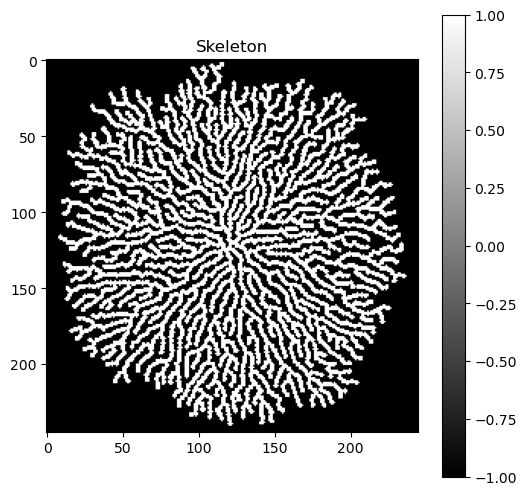

245


In [3]:
# Step 1: Load the RGB image
image_path = os.getcwd() + "\\Mycelium_model_real_image.png"
rgb_image = mpimg.imread(image_path)

# Step 2: Use only the first channel for simplicity
first_channel = rgb_image[:, :, 0]  # Extract the first channel
threshold = 0.5
skeleton = np.where(first_channel < threshold, 1, -1)  # Create bipolar image directly

# Step 3: Extract dimensions
dimensions = skeleton.shape
print(f"Dimensions of the bipolar image: {dimensions}")

# Step 4: Plot the bipolar image
plt.figure(figsize=(6, 6))
plt.title('Skeleton')
plt.imshow(skeleton, cmap='gray')
plt.colorbar()
plt.show()

numPoints = dimensions[0]
print(numPoints)

In [4]:
import torch
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self, num_points):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),  # Input is (t, x, y)
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 200),
            nn.Tanh(),
            nn.Linear(200, 100),
            nn.Tanh(),
            nn.Linear(100, num_points**2)   # Output will match the total grid points (num_points * num_points)
        )

        # Trainable parameters
        self.gamma = nn.Parameter(torch.tensor(625.0, requires_grad=True))  # Initial value of gamma
        self.gamma_ph = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Initial value of gamma_ph
        self.d = nn.Parameter(torch.tensor(30.0, requires_grad=True))  # Initial value of d
        self.p_alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Initial value of p_alpha
        self.p_b = nn.Parameter(torch.tensor(0.8, requires_grad=True))  # Initial value of p_b
        self.p_e = nn.Parameter(torch.tensor(2.6, requires_grad=True))  # Initial value of p_e
        self.T_r = nn.Parameter(torch.tensor(0.5, requires_grad=True))  # Initial value of T_r
        self.R = nn.Parameter(torch.tensor(0.04, requires_grad=True))   # Initial core radius

    def forward(self, x):
        """
        Forward pass of the PINN model.
        
        x: A tensor of shape [batch_size, 3], where each row is (t, x, y)
        
        Returns: A tensor of shape [num_points, num_points] for the 2D grid output.
        """
        # Pass the input through the network
        output = self.net(x)
        
        # Reshape the output into a 2D grid matching the size of the mesh grid
        return output.view(-1, num_points, num_points)  # Reshape to [batch_size, num_points, num_points]


In [5]:
# Define the a(u) function
def a(u, T_r, k=1):
    # Sigmoid-like switching function around the threshold T_r
    return 1 / (1 + torch.exp(-k * (u - T_r)))

In [6]:
# Penalty for partial derivative conditions
def condition_penalty(u, v, c, u_net):
    # Partial derivatives of f(u, v)
    df_du = u_net.p_alpha + 2 * u - u_net.p_b * v
    df_dv = - u_net.p_b * u
    
    # Partial derivatives of g(u, v)
    dg_du = 3 * u_net.p_e * u ** 2
    dg_dv = torch.tensor(-1.0,device=device)
    
    # Penalty terms (if conditions are violated)
    penalty_f_u = torch.mean(torch.relu(-df_du))  # Should be > 0
    penalty_f_v = torch.mean(torch.relu(df_dv))   # Should be < 0
    penalty_g_u = torch.mean(torch.relu(-dg_du))  # Should be > 0
    penalty_g_v = torch.mean(torch.relu(dg_dv))   # Should be < 0
    penalty_u = torch.mean(torch.relu(-u))
    penalty_c = torch.mean(torch.relu(-c))
    
    # Total penalty
    total_penalty = penalty_f_u + penalty_f_v + penalty_g_u + penalty_g_v + penalty_u + penalty_c
    return total_penalty

In [7]:
# Boundary loss (for Dirichlet boundary conditions)
def boundary_loss(t, x, y, u_net):
    input = torch.cat([t, x, y], dim=1)
    u = u_net(input)
    return torch.mean(u**2)  # u should be 0 on the boundary

In [8]:
# Physics loss (PDE residuals)
def physics_loss(t, x, y, u_net, v_net, c_net):
    u_residual, v_residual, c_residual = compute_pde_residuals(t, x, y, u_net, v_net, c_net)
    return torch.mean(u_residual**2) + torch.mean(v_residual**2) + torch.mean(c_residual**2)

In [9]:
# Total loss function (boundary + physics + condition penalties)
def pinn_loss(t_data, x_data, y_data, u_net, v_net, c_net):
    # Boundary loss
    b_loss = boundary_loss(t_data, x_data, y_data, u_net)
    
    # Physics loss
    p_loss = physics_loss(t_data, x_data, y_data, u_net, v_net, c_net)
    
    # Condition penalty (partial derivatives)
    input = torch.cat([t_data, x_data, y_data], dim=1)
    u = u_net(input)
    v = v_net(input)
    c_penalty = condition_penalty(u, v, u_net)
    
    # Total loss
    total_loss = b_loss + p_loss + c_penalty
    return total_loss

In [10]:
def generate_omega_c_boundary(c_tensor, input_, gamma, R):
    """
    Generate boundary points for Ω_c based on the exact definition, when c_tensor is a 1D tensor
    and input_ contains [t, x, y] coordinates.
    
    c_tensor: A tensor containing the values of c across the grid (1D vector).
    input_: A tensor containing [t, x, y] values for the grid points (2D tensor).
    gamma: The constant used to rescale space and time.
    R: Distance between the core and plasma membrane.
    """
    # Ensure input_ contains [t, x, y] and reshape if necessary
    x = input_[:, 1] # Extract x values
    y = input_[:, 2] # Extract y values
    
    # Identify the core (where c > 0.5)
    core_region = c_tensor > 0.15
    
    # Get the indices of the core region (where c > 0.5)
    core_indices = torch.nonzero(core_region, as_tuple=False)
    
    # If no core is found (in early iterations), return empty boundary points
    if core_indices.shape[0] == 0:
        print("Entered 1st break")
        return None, None

    # Extract the x and y coordinates of the core points
    core_x = x[core_indices].float()
    core_y = y[core_indices].float()

    # Compute the centroid (average position) of the core region as the central point x_c, y_c
    x_c = core_x.mean().item()  # Average x-coordinate
    y_c = core_y.mean().item()  # Average y-coordinate

    print(f"Centroid of core: x_c = {x_c}, y_c = {y_c}")

    # Calculate the distance from the centroid (x_c, y_c) to all other points
    dist_x = x - x_c
    dist_y = y - y_c
    distance_from_core = torch.sqrt(dist_x**2 + dist_y**2)
    
    # Identify points on the boundary where distance_from_core = R * sqrt(gamma)
    boundary_region = torch.isclose(distance_from_core, R * torch.sqrt(torch.tensor(gamma)).to(device), atol=0.01)

    # Get the boundary points
    boundary_indices = torch.nonzero(boundary_region, as_tuple=False)
    
    if boundary_indices.shape[0] == 0:
        print("Entered 2nd break")
        return None, None

    # Extract boundary x and y values from boundary_indices
    boundary_x = x[boundary_indices].view(-1, 1).to(device)
    boundary_y = y[boundary_indices].view(-1, 1).to(device)
    
    return boundary_x, boundary_y


In [11]:
def boundary_condition(x,y,t,custom_value):
    return torch.full_like(x,custom_value).to(device)

In [12]:
def generate_training_data(num_points):
    x = torch.rand(num_points, 1, requires_grad = True).to(device)
    y = torch.rand(num_points, 1, requires_grad = True).to(device)
    t = torch.rand(num_points, 1, requires_grad = True).to(device)
    return x,y,t

In [13]:
def generate_boundary_points(num_points):
    x_boundary = torch.tensor([0.0,1.0]).repeat(num_points//2).to(device)
    y_boundary = torch.rand(num_points).to(device)
    
    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary
        
    return x_boundary.view(-1,1), y_boundary.view(-1,1)

In [14]:
def generate_boundary_training_data(num_points):
    x_boundary, y_boundary = generate_boundary_points(num_points)
    t = torch.rand(num_points, 1, requires_grad=True).to(device)
    
    return x_boundary, y_boundary, t

In [15]:
# Compute PDE residuals
def compute_pde_residuals(t, x, y, u_net, v_net, c_net):
    input_data = torch.cat([t, x, y], dim=1)

    # Forward pass for u, v, c
    u = u_net(input_data)
    v = v_net(input_data)
    c = c_net(input_data)

    # First derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Second derivatives (gradients of gradients)
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Same for v and c
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    c_t = torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c), create_graph=True)[0]
    c_x = torch.autograd.grad(c, x, grad_outputs=torch.ones_like(c), create_graph=True)[0]
    c_y = torch.autograd.grad(c, y, grad_outputs=torch.ones_like(c), create_graph=True)[0]
    c_xx = torch.autograd.grad(c_x, x, grad_outputs=torch.ones_like(c_x), create_graph=True)[0]
    c_yy = torch.autograd.grad(c_y, y, grad_outputs=torch.ones_like(c_y), create_graph=True)[0]
    
    # Laplacians
    u_laplace = u_xx + u_yy
    v_laplace = v_xx + v_yy

    # f(u, v) and g(u, v)
    f_uv = u_net.p_alpha * u + u ** 2 - u_net.p_b * u * v
    g_uv = u_net.p_e * u ** 3 - v
    
    # Residuals
    u_residual = u_t - (u_laplace + u_net.gamma * f_uv)
    v_residual = v_t - (u_net.d * v_laplace + u_net.gamma * g_uv)
    c_residual = c_t - u_net.gamma_ph * c * (a(u, u_net.T_r) - c) * (c - 1)
    
    return u_residual, v_residual, c_residual

In [16]:
# Main code
# num_points = 100  # Grid resolution
# c_init, u_init, v_init = create_initial_conditions(num_points)

# # Convert to torch tensors
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# c_init_tensor = torch.tensor(c_init, dtype=torch.float32).unsqueeze(0).to(device)
# u_init_tensor = torch.tensor(u_init, dtype=torch.float32).unsqueeze(0).to(device)
# v_init_tensor = torch.tensor(v_init, dtype=torch.float32).unsqueeze(0).to(device)

# # Define networks for u, v, and c
# u_net = PINN_with_params([3, 64, 64, 1]).to(device)
# v_net = PINN_with_params([3, 64, 64, 1]).to(device)
# c_net = PINN_with_params([3, 64, 64, 1]).to(device)

# # Example data (replace with actual initial/boundary condition data)
# t_data = torch.zeros((num_points, 1), dtype=torch.float32, requires_grad=True).to(device)  # Time is zero for initial condition
# x_data = torch.tensor(np.linspace(0, 1, num_points).reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
# y_data = torch.tensor(np.linspace(0, 1, num_points).reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)

# Visualize initial conditions
#plot_initial_conditions(np.linspace(0, 1, num_points), np.linspace(0, 1, num_points), c_init, u_init, v_init)


In [17]:
def create_initial_conditions(num_points, square_size=0.2):
    """
    Create initial conditions for c, u, and v on a 2D grid.
    
    num_points: The number of points in each dimension (to form a num_points x num_points grid).
    square_size: The size of the square in the center where initial conditions are set.
    """
    x_min, x_max = 0.0, 1.0
    y_min, y_max = 0.0, 1.0

    # Create a meshgrid for the 2D domain
    x = torch.linspace(x_min, x_max, num_points)
    y = torch.linspace(y_min, y_max, num_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')

    # Initialize c, u, and v with zeros
    c_init = torch.zeros_like(X).to(device)
    u_init = torch.zeros_like(X).to(device)
    v_init = torch.zeros_like(X).to(device)

    # Define the center of the grid
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2

    # Set the initial conditions inside the square in the center
    inside_square = (X >= center_x - square_size / 2) & (X <= center_x + square_size / 2) & \
                    (Y >= center_y - square_size / 2) & (Y <= center_y + square_size / 2)

    # Assign values to the center square
    c_init[inside_square] = 1
    u_init[inside_square] = 1.0
    v_init[inside_square] = 0.1

    return X, Y, c_init, u_init, v_init


In [18]:
def plot_initial_conditions(X, Y, c_init, u_init, v_init):
    """
    Plot the initial conditions for c, u, and v on a 2D grid.
    
    X: 2D grid of x coordinates.
    Y: 2D grid of y coordinates.
    c_init: Initial condition tensor for c.
    u_init: Initial condition tensor for u.
    v_init: Initial condition tensor for v.
    """
    plt.figure(figsize=(18, 6))

    # Plot c_init
    plt.subplot(1, 3, 1)
    plt.contourf(X.cpu(), Y.cpu(), c_init.cpu(), levels=100, cmap="viridis")
    plt.colorbar(label='c_init')
    plt.title('Initial Condition for c')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Plot u_init
    plt.subplot(1, 3, 2)
    plt.contourf(X.cpu(), Y.cpu(), u_init.cpu(), levels=100, cmap="viridis")
    plt.colorbar(label='u_init')
    plt.title('Initial Condition for u')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Plot v_init
    plt.subplot(1, 3, 3)
    plt.contourf(X.cpu(), Y.cpu(), v_init.cpu(), levels=100, cmap="viridis")
    plt.colorbar(label='v_init')
    plt.title('Initial Condition for v')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()


In [19]:
path = os.getcwd() + "\\skeleton2outputs"

# Define the file paths
files = {
    "c_init":     path + "\\c_init.csv",
    "c_step_0":   path + "\\c_step_0.csv",
    "c_step_02": path + "\\c_step_100.csv",
    "c_step_04": path + "\\c_step_200.csv",
    "c_step_06": path + "\\c_step_300.csv",
    "c_step_08": path + "\\c_step_400.csv",
    "c_step_10": path + "\\c_step_500.csv",
    "u_init":     path + "\\u_init.csv",
    "u_step_0":   path + "\\u_step_0.csv",
    "u_step_02": path + "\\u_step_100.csv",
    "u_step_04": path + "\\u_step_200.csv",
    "u_step_06": path + "\\u_step_300.csv",
    "u_step_08": path + "\\u_step_400.csv",
    "u_step_10": path + "\\u_step_500.csv",
    "v_init":     path + "\\v_init.csv",
    "v_step_0":   path + "\\v_step_0.csv",
    "v_step_02": path + "\\v_step_100.csv",
    "v_step_04": path + "\\v_step_200.csv",
    "v_step_06": path + "\\v_step_300.csv",
    "v_step_08": path + "\\v_step_400.csv",
    "v_step_10": path + "\\v_step_500.csv"
}

def load_and_clean_csv(path):
    # Load the CSV file without headers (since the data seems to have no column names)
    df = pd.read_csv(path, header=None)
    return df

clean_dataframes = {name: load_and_clean_csv(path) for name, path in files.items()}

# Convert the cleaned pandas dataframes to PyTorch tensors
tensors = {name: torch.tensor(df.values, dtype=torch.float32).to(device) for name, df in clean_dataframes.items()}

# Example: Accessing c_init and c_step_0 tensors
c_init_tensor = tensors['c_init']
c_step_0_tensor = tensors['c_step_0']
c_step_02_tensor = tensors['c_step_02']
c_step_04_tensor = tensors['c_step_04']
c_step_06_tensor = tensors['c_step_06']
c_step_08_tensor = tensors['c_step_08']
c_step_10_tensor = tensors['c_step_10']

u_init_tensor = tensors['u_init']
u_step_0_tensor = tensors['u_step_0']
u_step_02_tensor = tensors['u_step_02']
u_step_04_tensor = tensors['u_step_04']
u_step_06_tensor = tensors['u_step_06']
u_step_08_tensor = tensors['u_step_08']
u_step_10_tensor = tensors['u_step_10']

v_init_tensor = tensors['v_init']
v_step_0_tensor = tensors['v_step_0']
v_step_02_tensor = tensors['v_step_02']
v_step_04_tensor = tensors['v_step_04']
v_step_06_tensor = tensors['v_step_06']
v_step_08_tensor = tensors['v_step_08']
v_step_10_tensor = tensors['v_step_10']

# Display tensors to check (optional)
print(c_init_tensor)
print(c_step_0_tensor)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


245
245


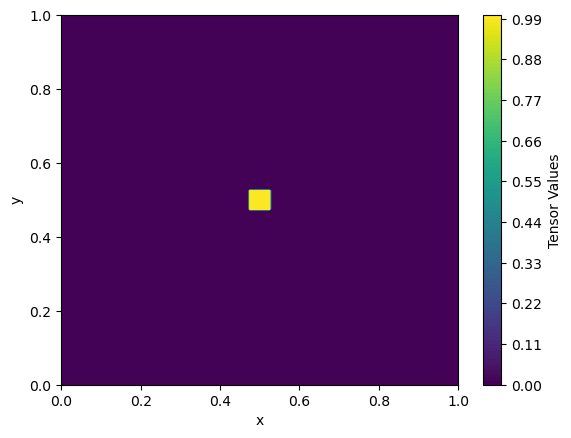

In [20]:
data = c_init_tensor.cpu().numpy() 

# Create a meshgrid (assuming square or rectangular data)
print(data.shape[0])
print(data.shape[1])
x = np.linspace(0, 1, data.shape[1])  # X coordinates (columns of the tensor)
y = np.linspace(0, 1, data.shape[0])  # Y coordinates (rows of the tensor)
X, Y = np.meshgrid(x, y)

# Plot the data using contourf
plt.contourf(X, Y, data, levels=100, cmap="viridis")
plt.colorbar(label="Tensor Values")
#plt.title(title)
plt.xlabel("x")
plt.ylabel("y")
plt.show()



c_init tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'))


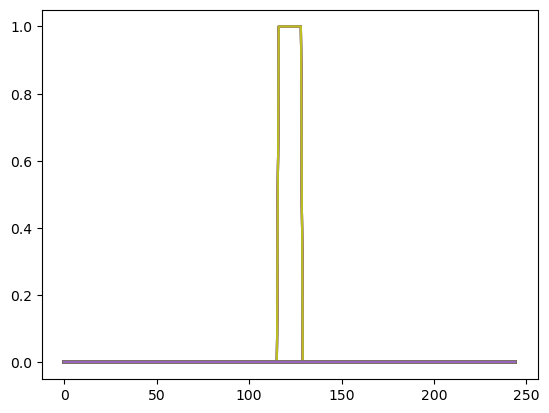

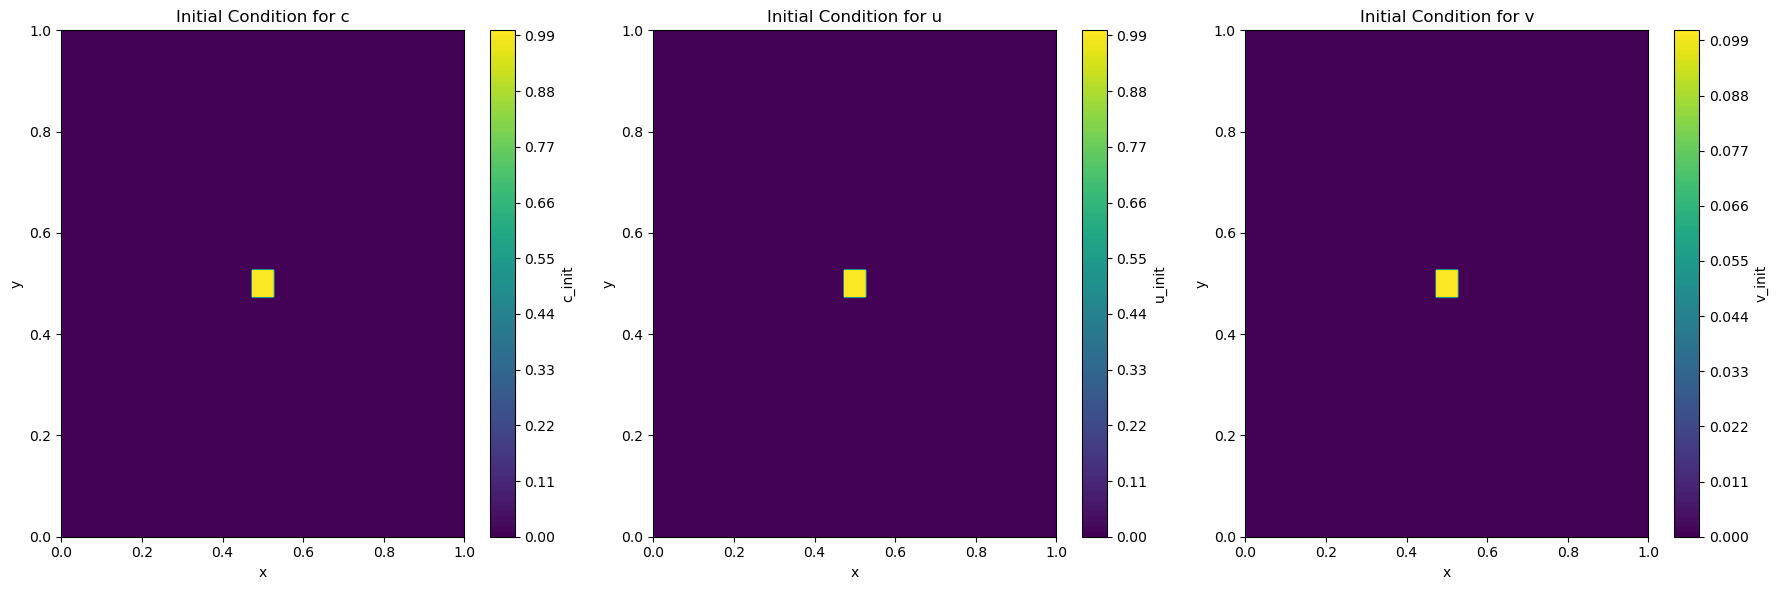

In [21]:
x,y,t = generate_training_data(245)
        
x_b, y_b, t_b = generate_boundary_training_data(245)

        
t_initial = torch.zeros_like(x)



X, Y, c_init, u_init, v_init = create_initial_conditions(245, square_size=0.05)

print(f'c_init {c_init})')


plt.plot(c_init.cpu().detach().numpy())

plot_initial_conditions(X, Y, c_init, u_init, v_init)

In [28]:
def train_PINN(u_net, c_net, v_net, num_iterations, num_points):
    optimiser = optim.Adam(list(u_net.parameters()) + list(v_net.parameters()) + list(c_net.parameters()), lr=1e-3)
    for epoch in range(num_iterations +1):
        optimiser.zero_grad()
        
        x,y,t = generate_training_data(num_points)
        #print(f'len x: {len(x)}')
        x_b, y_b, t_b = generate_boundary_training_data(num_points+1)
        
        t_initial = torch.zeros_like(x).to(device)
        
        X, Y, c_init, u_init, v_init = create_initial_conditions(num_points, square_size=0.05)
        
        # plt.contourf(X, Y, u_init.cpu().detach().numpy(), levels=100, cmap="viridis")
        # plt.colorbar(label='u initial')
        # plt.title('Predicted u')
        # plt.xlabel('x')
        # plt.ylabel('y')
        # plt.show()
        
        input_ = torch.cat([t, x, y], dim=1)
        
        #print(f'input: {input_.shape}')
        
        input_init = torch.cat([t_initial, x, y], dim=1)
        
        #print(f'c_tensor: {c_net(input_)}')
        #print(f'input: {input_}')
        u_pred = u_net(input_)
        # #print(f'u_pred: {u_pred}')
        n = u_pred.shape[0]
        # # Reshape u_pred to match the grid (num_points x num_points)
        
        X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))

        
        # Plot the result
        # plt.contourf(X, Y, u_pred[0].cpu().detach().numpy(), levels=100, cmap="viridis")
        # plt.colorbar(label='u prediction')
        # plt.title('Predicted u')
        # plt.xlabel('x')
        # plt.ylabel('y')
        # plt.show()
        
        custom_value = 0
        # if epoch==0:
        #     ub_xPoint, ub_yPoint = generate_omega_c_boundary(u_init, input_, u_net.gamma, u_net.R)
        # else:
        #     ub_xPoint, ub_yPoint = generate_omega_c_boundary(u_net(input_), input_, u_net.gamma, u_net.R)
        
        #print(f'ub_xPoint: {ub_xPoint}')
        #print(f'xb: {x_b}')
        
       # if ub_xPoint is not None and ub_yPoint is not None:
        # Apply the boundary condition only if valid boundary points are found
        
        # t_ub = torch.rand(len(ub_xPoint), 1, requires_grad=True).to(device)
        # u_boundary_x = boundary_condition(ub_xPoint, ub_yPoint, t_ub, custom_value)
        # u_boundary_y = boundary_condition(ub_yPoint, ub_xPoint, t_ub, custom_value)
        
        
        # else:
        #     print("No valid boundary points for Ω_c were found in this iteration. Initialising as 0")
        #     u_boundary_x = 0.0
        #     u_boundary_y = 0.0
        
        v_boundary_x = boundary_condition(x_b,y_b,t_b,custom_value)
        v_boundary_y = boundary_condition(y_b,x_b,t_b,custom_value)
        
        c_boundary_x = boundary_condition(x_b,y_b,t_b,custom_value)
        c_boundary_y = boundary_condition(y_b,x_b,t_b,custom_value)
        
        # input_ub = torch.cat([t_ub, ub_xPoint, ub_yPoint],dim=1)
        # input_ub_mirror = torch.cat([t_ub, ub_xPoint, ub_yPoint],dim=1)
        
        input_cb = torch.cat([t_b, c_boundary_x, c_boundary_y],dim=1)
        input_cb_mirror = torch.cat([t_b, c_boundary_y, c_boundary_x],dim=1)
        
        input_vb = torch.cat([t_b, v_boundary_x, v_boundary_y],dim=1)
        input_vb_mirror = torch.cat([t_b, v_boundary_y, v_boundary_x],dim=1)
        
        u_res, v_res, c_res = compute_pde_residuals(t,x,y,u_net,v_net,c_net)
        
        penalty = condition_penalty(u_net(input_),v_net(input_), v_net(input_), u_net)
        
        tt = torch.ones_like(t) # baseline for checkpoints
        input_02 = torch.cat([tt*0.2, x, y], dim=1)
        input_04 = torch.cat([tt*0.4, x, y], dim=1)
        input_06 = torch.cat([tt*0.6, x, y], dim=1)
        input_08 = torch.cat([tt*0.8, x, y], dim=1)
        input_10 = torch.cat([tt*1.0, x, y], dim=1)
        
        
        loss =  100*nn.MSELoss()(u_init, torch.clamp(u_net(input_init)[0],0.0,30.0))+\
                100*nn.MSELoss()(c_init, c_net(input_init)[0])+\
                100*nn.MSELoss()(v_init, v_net(input_init)[0])+\
                nn.MSELoss()(torch.clamp(u_net(input_cb),0.0,30.0),torch.zeros_like(c_net(input_cb)))+\
                nn.MSELoss()(u_net(input_cb_mirror),torch.zeros_like(c_net(input_cb_mirror)))+\
                nn.MSELoss()(u_net(input_vb),torch.zeros_like(v_net(input_vb)))+\
                nn.MSELoss()(v_net(input_vb_mirror),torch.zeros_like(v_net(input_vb_mirror)))+\
                nn.MSELoss()(u_res, torch.zeros_like(u_res))+\
                nn.MSELoss()(v_res, torch.zeros_like(v_res))+\
                nn.MSELoss()(c_res, torch.zeros_like(c_res))+\
                nn.MSELoss()(c_step_02_tensor, c_net(input_02))+\
                nn.MSELoss()(c_step_04_tensor, c_net(input_04))+\
                nn.MSELoss()(c_step_06_tensor, c_net(input_06))+\
                nn.MSELoss()(c_step_08_tensor, c_net(input_08))+\
                nn.MSELoss()(c_step_10_tensor, c_net(input_10))+\
                nn.MSELoss()(v_step_02_tensor, v_net(input_02))+\
                nn.MSELoss()(v_step_04_tensor, v_net(input_04))+\
                nn.MSELoss()(v_step_06_tensor, v_net(input_06))+\
                nn.MSELoss()(v_step_08_tensor, v_net(input_08))+\
                nn.MSELoss()(v_step_10_tensor, v_net(input_10))+\
                nn.MSELoss()(u_step_02_tensor, u_net(input_02))+\
                nn.MSELoss()(u_step_04_tensor, u_net(input_04))+\
                nn.MSELoss()(u_step_06_tensor, u_net(input_06))+\
                nn.MSELoss()(u_step_08_tensor, u_net(input_08))+\
                nn.MSELoss()(u_step_10_tensor, u_net(input_10))+ 100*penalty
                # nn.MSELoss()(u_net(input_ub),torch.zeros_like(u_net(input_ub)))+\
                # nn.MSELoss()(u_net(input_ub_mirror),torch.zeros_like(u_net(input_ub_mirror)))+\
                    
        loss.backward()
        optimiser.step()
        
        if epoch % 100 ==0:
            print(f"itration:, {epoch}, loss:, {loss}" )
            
            tt = torch.ones_like(t) * 0.5
            input_ = torch.cat([tt, x, y], dim=1)
            u_pred = u_net(input_)
            #print(f'u_pred: {u_pred}')
            n = u_pred.shape[0]
            # Reshape u_pred to match the grid (num_points x num_points)
            
            X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))

            
            # Plot the result
            plt.contourf(X, Y, u_pred[0].cpu().detach().numpy(), levels=100, cmap="viridis")
            plt.colorbar(label='u prediction')
            plt.title('Predicted u')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.show()
        
        

c:\Users\georg\anaconda3\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\georg\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([245, 245, 245])) that is different to the input size (torch.Size([245, 245])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


itration:, 0, loss:, 2282829.25


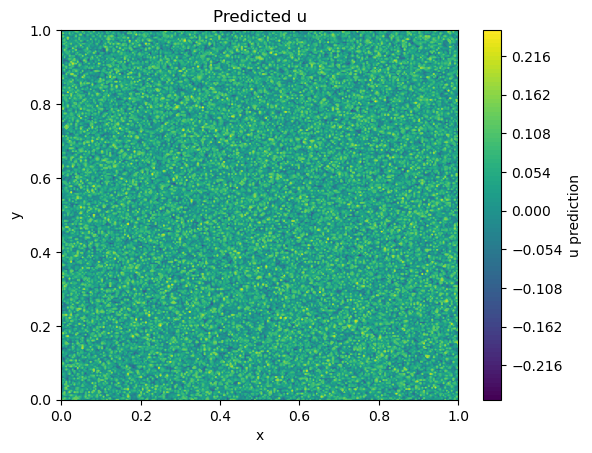

In [ ]:
num_iterations = 10000
num_points = 245
u_net = PINN(num_points).to(device)
v_net = PINN(num_points).to(device)
c_net = PINN(num_points).to(device)
train_PINN(u_net, c_net, v_net, num_iterations, num_points)